# W266 Russian Troll Detection Project

# LSTM Notebook, Including Metadata

## Quick Status:  Tweet and User Metadata Incorporated; Variable Length LSTM enabled

This notebook takes the output of our Pre-Processing work (embedded tweet texts and metadata, see other notebooks) and runs it through an LSTM.

In [1]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436324 kB
MemFree:        14612340 kB
MemAvailable:   15603708 kB


In [2]:
#Main Libraries
import numpy as np
from random import shuffle
import tensorflow as tf
import pandas as pd  
from sklearn.datasets import fetch_mldata
from sklearn.preprocessing import (OneHotEncoder, StandardScaler)

import timeit  #For timing

#Accuracy reporting / plotting
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score)
import itertools
from collections import (defaultdict, OrderedDict)
from operator import itemgetter

/home/brandon_cummings/.local/lib/python3.5/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [3]:
#Plotting (re-running this cell causes long errors)
import matplotlib
matplotlib.use('Agg')  #Necessary to prevent display errors
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.display.max_columns = 50

In [4]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436324 kB
MemFree:        14366180 kB
MemAvailable:   15487240 kB


## Load and Shuffle Data

In [5]:
data_filename = 'data/df_mini_alltweets_with_embed.pkl'
df_alltweets = pd.read_pickle(data_filename)

#Remove all retweets
df_alltweets = df_alltweets[df_alltweets['retweeted_status_id'] == 0]

#Keep only retweets (must comment out line above, and must change train dev test cutoff points below)
#df_alltweets = df_alltweets[df_alltweets['retweeted_status_id'] != 0]

In [6]:
df_alltweets

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text
0,564839233957818369,"Either, we heal, now, as a team, or we will di...",0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[either, ,, we, heal, ,, now, ,, as, a, team, ...","[[0.32019, 0.081182, -0.080413, -0.0066426, -0..."
1,676409305944469504,RT @AmyMek: Shaker Aamer is not even a citizen...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, shaker, aamer, is, ...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
2,564822564556382208,https://t.co/5jtxjrQrKa just watch it),0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[<url>, just, watch, it, )]","[[0.55283, -0.57581, -0.76596, -1.1371, 0.2205..."
3,614985782739087360,"RT @_wintergirl93: Dude, seriously? Go away. h...",0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, dude, ,, seriously,...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
4,578247211655434240,What is he doing?? http://t.co/w19JHah4pV,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[what, is, he, doing, ?, <repeat>, <url>]","[[0.71441, 0.46241, 0.028374, 0.07638, -0.0030..."
5,689503880091021312,RT @BringTheFlag: Iran to Begin Construction o...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, iran, to, begin, co...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
6,564830562670501888,"We turn, not older with years, but newer every...",0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[we, turn, ,, not, older, with, years, ,, but,...","[[0.70057, 1.2429, 0.14358, -0.047923, -0.2265..."
7,564821530824015873,To be able to say how much you love is to love...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[to, be, able, to, say, how, much, you, love, ...","[[0.54964, 0.032752, 0.19354, -0.51119, -0.394..."
8,673889392025600001,RT @keriqbaum: Mondays be like... https://t.co...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, mondays, be, like, ...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
9,554292771658268674,Literally why people voted for him http://t.co...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[literally, why, people, voted, for, him, <url>]","[[0.35106, 0.43278, 1.0263, -0.71624, -0.2855,..."


In [7]:
!cat /proc/meminfo | grep Mem

MemTotal:       16436324 kB
MemFree:        11148916 kB
MemAvailable:   13601472 kB


In [8]:
#Tweet Counts by Target Value
df_alltweets['target'].value_counts()

1    163810
0    102997
Name: target, dtype: int64

In [9]:
#Verify we've removed all retweets
df_alltweets[df_alltweets['retweeted_status_id'] != 0]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text


In [10]:
df_alltweets.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266807 entries, 0 to 342856
Data columns (total 18 columns):
tweet_id                 266807 non-null int64
text                     266807 non-null object
user_id                  266807 non-null int64
in_reply_to_status_id    266807 non-null float64
retweeted_status_id      266807 non-null float64
retweet_count            266807 non-null float32
favorite_count           266807 non-null float32
num_hashtags             266807 non-null float32
num_urls                 266807 non-null float32
num_mentions             266807 non-null float64
target                   266807 non-null int8
statuses_count           266807 non-null float64
followers_count          266807 non-null float64
friends_count            266807 non-null float64
favourites_count         266807 non-null float64
listed_count             266807 non-null float64
text_cantok              266807 non-null object
embedded_text            266807 non-null object
dtypes: float32(4

In [11]:
#Shuffle the data
df_alltweets = df_alltweets.sample(frac=1, axis=0).reset_index(drop=True)
df_alltweets

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text
0,793661199137202176,KKK’s official newspaper supports Donald Trump...,2743327187,0.000000e+00,0.0,0.0,0.0,1.0,1.0,0.0,1,28939.0,31729.0,12148.0,31.0,263.0,"[k, <elong>, ’, s, official, newspaper, suppor...","[[0.58504, -0.036245, 0.41896, -1.0191, -0.120..."
1,588266223210778624,Whoa nice #TheFlash @emmykinney http://t.co/fM...,587826392,0.000000e+00,0.0,0.0,1.0,1.0,0.0,1.0,0,75903.0,1183.0,308.0,5085.0,26.0,"[whoa, nice, <hashtag>, theflash, <user>, <url>]","[[0.43004, 0.27873, 0.62215, -0.61467, 0.00420..."
2,576475063030980608,"our bus has wifi, air conditioners, cup holder...",2159707566,0.000000e+00,0.0,1.0,9.0,0.0,0.0,0.0,0,9899.0,324.0,196.0,4208.0,2.0,"[our, bus, has, wifi, ,, air, conditioners, ,,...","[[0.1519, 0.042114, 0.3913, 0.45826, 0.54624, ..."
3,550814326123409408,Y'all,1669189561,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,9404.0,2354.0,1710.0,2289.0,2.0,"[y, ', all]","[[-0.76372, 0.84481, -0.9094, 0.16341, -0.1135..."
4,432266985158627328,Style. http://t.co/Dod02xslXK,1945485462,0.000000e+00,0.0,0.0,0.0,0.0,1.0,0.0,0,1184.0,305.0,318.0,731.0,0.0,"[style, ., <url>]","[[-0.58874, -0.49309, 0.16066, -0.016976, 0.89..."
5,792852618800402479,'Voters who haven't yet settled on a candidate...,3990577513,0.000000e+00,0.0,1.0,1.0,0.0,0.0,0.0,1,1649.0,19976.0,21908.0,928.0,97.0,"[', voters, who, haven, ', t, yet, settled, on...","[[-0.13814, -0.071804, 0.0003659, 0.98528, 0.0..."
6,880409251470090240,RT @ZDFheute: Rund um den G20-Gipfel: Berlin v...,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, rund, um, den, g<nu...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
7,578219146401419264,Think of all the beauty still left around you ...,1656685598,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1999.0,3242.0,3420.0,1863.0,35.0,"[think, of, all, the, beauty, still, left, aro...","[[0.39749, 0.52614, 0.060631, -0.0474, -0.5239..."
8,826161306092892169,RT @carrieksada: Amazing how @SenSchumer can m...,2533653547,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1831.0,2668.0,2884.0,1325.0,46.0,"[rt, <allcaps>, <user>, :, amazing, how, <user...","[[0.68243, 0.73589, 0.017529, -0.13763, 0.3602..."
9,563971534436315136,@jessicaestewart @GOPublicSchools @FremontTige...,13971722,5.639696e+17,0.0,1.0,1.0,0.0,1.0,3.0,0,23274.0,1484.0,1307.0,320.0,43.0,"[<user>, <user>, <user>, this, is, the, story,...","[[0.78704, 0.72151, 0.29148, -0.056527, 0.3168..."


In [12]:
df_alltweets.info(memory_usage='deep', verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266807 entries, 0 to 266806
Data columns (total 18 columns):
tweet_id                 266807 non-null int64
text                     266807 non-null object
user_id                  266807 non-null int64
in_reply_to_status_id    266807 non-null float64
retweeted_status_id      266807 non-null float64
retweet_count            266807 non-null float32
favorite_count           266807 non-null float32
num_hashtags             266807 non-null float32
num_urls                 266807 non-null float32
num_mentions             266807 non-null float64
target                   266807 non-null int8
statuses_count           266807 non-null float64
followers_count          266807 non-null float64
friends_count            266807 non-null float64
favourites_count         266807 non-null float64
listed_count             266807 non-null float64
text_cantok              266807 non-null object
embedded_text            266807 non-null object
dtypes: float32(4

## Extract Tweet Text

In [13]:
#Extract just the values for the LSTM piece of the model
X = df_alltweets['embedded_text'].values
Y = df_alltweets['target'].values
print(X.shape)
print(X[0].shape)
print(X[1].shape)
print(X[2].shape)
print(Y)
print(Y.shape)

(266807,)
(14, 50)
(6, 50)
(13, 50)
[1 0 0 ... 0 0 1]
(266807,)


Looks like we're in good shape!  Har har har ...

### Pad / Trim Tweets

In [14]:
#Pad / trim tweets
time_start = timeit.default_timer()

#First get their length
tweet_length_list = []
for tweet in X:
    tweet_length_list.append(len(tweet))

#Find the cutoff percentile (100 results in no trim)
cutoff_percentile = 99.5
print('Cutoff Percentile: ', cutoff_percentile)
cutoff_length = int(np.percentile(tweet_length_list, cutoff_percentile))
print('Cutoff Length: ', cutoff_length)

#Now pad / trim each tweet
for i, tweet in enumerate(X):
    if len(tweet) > cutoff_length:
        #Trim
        X[i] = X[i][0:cutoff_length]
    if len(tweet) < cutoff_length:        
        #Pad
        X[i] = np.vstack((X[i], np.zeros((cutoff_length - len(X[i]), 50))))
        
#Note, we're actually updating the 'embedded_text' valuues in the df_alltweets dataframe, 
    #giving it a MUCH bigger memory footprint.
    
#Timing
time_end = timeit.default_timer()
print('Time to run cell: {:.1f} seconds'.format(time_end - time_start))

Cutoff Percentile:  99.5
Cutoff Length:  40
Time to run cell: 7.6 seconds


In [15]:
X[1].shape

(40, 50)

In [16]:
#Convert to single array
X = np.stack(X)
print(X.shape)
print(Y.shape)

(266807, 40, 50)
(266807,)


In [17]:
#Convert labes to One Hot
y_hot = np.array(pd.get_dummies(Y))

print('Data shape: ', X.shape)
print('Label shape (original):', Y.shape)
print('Label shape (one hot):', y_hot.shape)
y_hot.view()

Data shape:  (266807, 40, 50)
Label shape (original): (266807,)
Label shape (one hot): (266807, 2)


array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

## Split Data into Train, Dev, Test

In [18]:
# Split test, dev, and training data.
cutoff_train_dev = 225000
cutoff_dev_test = 250000  #Shrinking this to potentially prevent TF errors calculating #incorrect
cutoff_test_end = 40000  #Setting this also helps prevent errors ... need to consider batches for post hoc analysis
truncate_test_data = False

if truncate_test_data == False:
    cutoff_test_end = None


train_data, train_labels = X[:cutoff_train_dev], y_hot[:cutoff_train_dev]
dev_data, dev_labels = X[cutoff_train_dev:cutoff_dev_test], y_hot[cutoff_train_dev:cutoff_dev_test]
test_data, test_labels = X[cutoff_dev_test:cutoff_test_end], y_hot[cutoff_dev_test:cutoff_test_end]

print(train_data[77].shape)
print(train_labels[77].shape)
print(train_data[77])
print(train_labels[77])

(40, 50)
(2,)
[[ 0.68243003  0.73588997  0.017529   ...  0.14771     0.080503
  -0.68115002]
 [ 1.12660003 -0.61615998 -0.70096999 ... -0.77548999 -0.71455002
  -0.49902999]
 [ 0.78704     0.72150999  0.29148    ...  0.080107   -0.075323
  -0.61461002]
 ...
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]]
[0 1]


In [19]:
print(train_data.shape)
print(dev_data.shape)
print(test_data.shape)
print(train_labels)
print(dev_labels)
print(test_labels)

(225000, 40, 50)
(25000, 40, 50)
(16807, 40, 50)
[[0 1]
 [1 0]
 [1 0]
 ...
 [1 0]
 [1 0]
 [0 1]]
[[1 0]
 [1 0]
 [0 1]
 ...
 [0 1]
 [1 0]
 [0 1]]
[[0 1]
 [0 1]
 [0 1]
 ...
 [1 0]
 [1 0]
 [0 1]]


### Generate sequence lengths

In [20]:
#Generate sequence lengths
sequence_lens = np.array(df_alltweets['text_cantok'].apply(len))
df_alltweets['seq_len_cantok'] = sequence_lens  #Also add it to the dataframe
sequence_lens = np.minimum(sequence_lens,cutoff_length)  #Max length to feed into model

#split seq_len into train, dev, test
sequence_lens_train = sequence_lens[0:cutoff_train_dev]
sequence_lens_dev = sequence_lens[cutoff_train_dev:cutoff_dev_test]
sequence_lens_test = sequence_lens[cutoff_dev_test:cutoff_test_end]

print(sequence_lens.shape)
print(sequence_lens_train.shape)
print(sequence_lens_dev.shape)
print(sequence_lens_test.shape)

sequence_lens

(266807,)
(225000,)
(25000,)
(16807,)


array([14,  6, 13, ..., 13,  6, 15])

## Explore Metadata

Commenting this whole section to save space.  But conclusions at the bottom still hold.

In [21]:
# col_names = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions', 'target']
# features = df_alltweets[col_names]

# features[features['target'] == 0].describe(include='all')

In [22]:
# features[features['target'] == 1].describe(include='all')

In [23]:
# #Generate Plot Data
# value_cols = list(set(col_names) - set({'target'}))
# plot_data = pd.melt(features, id_vars=['target'], value_vars=value_cols)
# plot_data.head()

In [24]:
# print('GENUINE TWEETS')
# print(df_alltweets[df_alltweets['target'] == 0]['num_urls'].value_counts())
# print('\nRUSSIAN TWEETS')
# print(df_alltweets[df_alltweets['target'] == 1]['num_urls'].value_counts())

# #Almost no genuine tweets have > 1 URL.

In [25]:
# print('GENUINE TWEETS')
# print(df_alltweets[df_alltweets['target'] == 0]['num_hashtags'].value_counts())
# print('\nRUSSIAN TWEETS')
# print(df_alltweets[df_alltweets['target'] == 1]['num_hashtags'].value_counts())

In [26]:
# single_plot_data = plot_data[plot_data['variable'] == 'num_hashtags']
# sns.violinplot(x='variable', y='value', hue='target', data=single_plot_data)
# plt.ylim(0, 10)

In [27]:
# print('GENUINE TWEETS')
# print(df_alltweets[df_alltweets['target'] == 0]['num_mentions'].value_counts())
# print('\nRUSSIAN TWEETS')
# print(df_alltweets[df_alltweets['target'] == 1]['num_mentions'].value_counts())

In [28]:
# single_plot_data = plot_data[plot_data['variable'] == 'num_mentions']
# sns.violinplot(x='variable', y='value', hue='target', data=single_plot_data)
# plt.ylim(0, 10)

In [29]:
# print('GENUINE TWEETS')
# print(df_alltweets[df_alltweets['target'] == 0]['retweet_count'].value_counts())
# print('\nRUSSIAN TWEETS')
# print(df_alltweets[df_alltweets['target'] == 1]['retweet_count'].value_counts())

# #Russian tweets have lower retweet counts, but worth exploring visually.

In [30]:
# single_plot_data = plot_data[plot_data['variable'] == 'retweet_count']
# sns.boxplot(x='variable', y='value', hue='target', data=single_plot_data)
# plt.ylim(0, 4)

In [31]:
# print('GENUINE TWEETS')
# print(df_alltweets[df_alltweets['target'] == 0]['favorite_count'].value_counts())
# print('\nRUSSIAN TWEETS')
# print(df_alltweets[df_alltweets['target'] == 1]['favorite_count'].value_counts())

# #Russian tweets have lower retweet counts, but worth exploring visually.

### Metadata Findings

Findings, the Russian tweets seem to have ...
  * retweet_count:  Similar mean, much lower std, much lower max
  * favorite_count:  Much higher mean, much higher std, much higher max
  * num_hashtags:  Higher mean, similar std, higher max
  * num_urls:  Similar mean, higher std, much higher max
  * num_mentions:  Lower mean, similar std, similar max

With most of this data as zero, it's hard to conclude that it would sway findings significantly.

Moreover, it's nearly impossible to determine whether Russian tweets inherently have different metadata characteristics.  In other words, it's hard to know if there's something different about the metadata in these two data sets that wouldn't be found in other data.

## Extract and Scale Metadata

In [32]:
#Scale metadata columns
col_names = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
             'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count',
             'seq_len_cantok'
            ]

#Updated to exclude dominant columns ('statuses_count', 'followers_count', 'friends_count', 'favourites_count')
col_names = ['retweet_count', 'favorite_count', 'num_hashtags', 'num_urls', 'num_mentions',
             'listed_count',
             'seq_len_cantok'
            ]

metadata = StandardScaler().fit_transform(df_alltweets[col_names].values)
meta_dim = metadata.shape[1]
print(metadata.shape)
metadata

(266807, 7)


array([[-0.06388636, -0.06276219,  0.95363972, ..., -0.39648847,
         1.73349538, -0.30083042],
       [-0.06388636, -0.05489253,  0.95363972, ...,  1.30457765,
        -0.08217635, -1.18689561],
       [-0.05657367,  0.00806481, -0.56678953, ..., -0.39648847,
        -0.26604184, -0.41158857],
       ...,
       [-0.05657367, -0.05489253, -0.56678953, ...,  1.30457765,
        -0.28136396, -0.41158857],
       [-0.06388636, -0.06276219, -0.56678953, ..., -0.39648847,
        -0.19709228, -1.18689561],
       [-0.06388636, -0.06276219, -0.56678953, ..., -0.39648847,
        -0.28136396, -0.19007227]])

In [33]:
#Split metadata
train_metadata = metadata[:cutoff_train_dev]
dev_metadata = metadata[cutoff_train_dev:cutoff_dev_test]
test_metadata = metadata[cutoff_dev_test:cutoff_test_end]

print(train_metadata.shape)
print(dev_metadata.shape)
print(test_metadata.shape)

(225000, 7)
(25000, 7)
(16807, 7)


In [34]:
cutoff_test_end

In [35]:
print(test_data.shape)
print(test_labels.shape)
print(test_metadata.shape)

(16807, 40, 50)
(16807, 2)
(16807, 7)


In [36]:
meta_dim

7

In [37]:
#!cat /proc/meminfo | grep Mem

## TensorFlow !

First, we'll build our model:

In [38]:
#Design the TF Model
tf.reset_default_graph() # fixes our reuse of variables problem

#Model parameters
epoch = 20  #Pretty good after 10 (with batch size = 500)
batch_size = 500
lrn_rate = 0.001  #Default is 0.001
ep = 1e-08  #Default is 1e-08
hidden_lstm_size = 32     #Research paper was 32
hidden_meta_h1_size = 128 #Research paper was 128
hidden_meta_h2_size = 64  #Research paper was 64


#Model inputs
data = tf.placeholder(tf.float32, [None, cutoff_length, 50])  #[batch_size, max_seq_length, num_features]
target = tf.placeholder(tf.float32, [None, 2])    #[batch_size, output_length = num_classes]
meta = tf.placeholder(tf.float32, [None, meta_dim])    #[batch_size, meta_dim]

#BEFORE: data [bs, 27, 50] --> LSTM [bs, 34] --> Softmax [bs, 2]
#AFTER:  data [bs, 27, 50] --> LSTM [bs, 34] --> meta [bs, 34+meta_dim] --> Softmax [bs, 2]

#LSTM Layer
seq_lens = tf.placeholder(tf.int32, [None])  #[batch_size]  #Sequence Lengths
cell = tf.nn.rnn_cell.LSTMCell(hidden_lstm_size,state_is_tuple=True)
val, state = tf.nn.dynamic_rnn(cell, data, sequence_length=seq_lens, dtype=tf.float32)

#Append metadata to LSTM end state (last) vector
#Remember, 'meta' is the tensor name, 'metadata' is the actual data we supply to feed_dict (when we execute below)
use_meta = False
if use_meta:
    meta_last = tf.concat([state[1], meta], axis=1)
else:
    meta_last = state[1]
    meta_dim = 0

#Post-LSTM Hidden Layer 1
weight_meta_h1 = tf.Variable(tf.truncated_normal([hidden_lstm_size + meta_dim, hidden_meta_h1_size]))  #[bs, 34+meta_dim, h1]
bias_meta_h1 = tf.Variable(tf.constant(0.1, shape=[hidden_meta_h1_size]))  #[bs, h1]
x_meta_h1 = tf.nn.relu(tf.matmul(meta_last, weight_meta_h1) + bias_meta_h1)

#Post-LSTM Hidden Layer 2
weight_meta_h2 = tf.Variable(tf.truncated_normal([hidden_meta_h1_size, hidden_meta_h2_size]))  #[bs, h1, h2]
bias_meta_h2 = tf.Variable(tf.constant(0.1, shape=[hidden_meta_h2_size]))  #[bs, h2]
#x_meta_h2 = tf.matmul(meta_last, weight_meta_h2) + bias_meta_h2
x_meta_h2 = tf.nn.relu(tf.matmul(x_meta_h1, weight_meta_h2) + bias_meta_h2)

#Softmax Layer (final output)
#Note the weight dimension changed from hidden_lstm_size to hidden_lstm_size + meta_dim
weight_final = tf.Variable(tf.truncated_normal([hidden_lstm_size, int(target.get_shape()[1])]))  #[bs, h2, 2]
bias_final = tf.Variable(tf.constant(0.1, shape=[target.get_shape()[1]]))  #[bs, 2]
prediction = tf.nn.softmax(tf.matmul(meta_last, weight_final) + bias_final)

#Loss Function
cross_entropy = -tf.reduce_sum(target * tf.log(tf.clip_by_value(prediction,1e-10,1.0)))
optimizer = tf.train.AdamOptimizer(learning_rate=lrn_rate, epsilon=ep)
minimize = optimizer.minimize(cross_entropy)

mistakes = tf.not_equal(tf.argmax(target, axis=1), tf.argmax(prediction, axis=1))
error = tf.reduce_mean(tf.cast(mistakes, tf.float32))

In [39]:
#Execute the model!
time_start = timeit.default_timer()

init_op = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init_op)

no_of_batches = int(len(train_data)/batch_size)
print("Number of batches: {}".format(no_of_batches))
for i in range(epoch):
    ptr = 0
    batch_num = 1
    for j in range(no_of_batches):
        batch_num+=1
        inp, out = train_data[ptr:ptr+batch_size], train_labels[ptr:ptr+batch_size]
        seq_lens_batch = sequence_lens_train[ptr:ptr+batch_size]
        meta_inp = train_metadata[ptr:ptr+batch_size]
        ptr+=batch_size
        #feed_dict format = {tensor_name: data, tensor_name2: data2, etc.}
        sess.run(
            minimize,
            feed_dict=
            {
                data: inp,
                target: out,
                seq_lens: seq_lens_batch,
                #meta: meta_inp
            }
        )
    
    print("Epoch -", str(i + 1), end='')
    #incorrect = sess.run(error, {data: dev_data, target: dev_labels, seq_lens: sequence_lens_dev, meta: dev_metadata})
    incorrect = sess.run(error, {data: dev_data, target: dev_labels, seq_lens: sequence_lens_dev})
    print(': Error = {:3.2f}%.  '.format(100 * incorrect), end='')
    
    #Timing
    time_epoch = timeit.default_timer()
    print('Time to train {} epoch(s): {:.0f} seconds'.format(i+1, time_epoch - time_start))

#Running this at the end to manually test accuracy
#Recall, preds is a softmax, so floats, not ints
print('Fetch numerous tensors for post hoc analysis ... ', end='')

preds, targs = \
    sess.run([prediction, target], 
             #{data: test_data, target: test_labels, seq_lens: sequence_lens_test, meta: test_metadata}
             {data: test_data, target: test_labels, seq_lens: sequence_lens_test}
            )
            

print('done!')

sess.close()

#Timing
time_end = timeit.default_timer()
print('Time to run cell: {:.0f} seconds'.format(time_end - time_start))

Number of batches: 450
Epoch - 1: Error = 7.46%.  Time to train 1 epoch(s): 54 seconds
Epoch - 2: Error = 6.45%.  Time to train 2 epoch(s): 107 seconds
Epoch - 3: Error = 6.06%.  Time to train 3 epoch(s): 159 seconds
Epoch - 4: Error = 5.89%.  Time to train 4 epoch(s): 212 seconds
Epoch - 5: Error = 5.69%.  Time to train 5 epoch(s): 265 seconds
Epoch - 6: Error = 5.60%.  Time to train 6 epoch(s): 318 seconds
Epoch - 7: Error = 5.57%.  Time to train 7 epoch(s): 370 seconds
Epoch - 8: Error = 5.53%.  Time to train 8 epoch(s): 422 seconds
Epoch - 9: Error = 5.40%.  Time to train 9 epoch(s): 475 seconds
Epoch - 10: Error = 5.30%.  Time to train 10 epoch(s): 527 seconds
Epoch - 11: Error = 5.30%.  Time to train 11 epoch(s): 579 seconds
Epoch - 12: Error = 5.21%.  Time to train 12 epoch(s): 631 seconds
Epoch - 13: Error = 5.19%.  Time to train 13 epoch(s): 683 seconds
Epoch - 14: Error = 5.09%.  Time to train 14 epoch(s): 735 seconds
Epoch - 15: Error = 5.08%.  Time to train 15 epoch(s): 787

In [40]:
#!cat /proc/meminfo | grep Mem

## Results Analysis

In [41]:
#Manual accuracy check with test data!
test_range = test_data.shape[0]
correct = 0
for i in range(test_range):
    if int(preds[i][0]+0.5) == int(targs[i][0]):
        correct += 1
        
print('Test Set Accuracy: {:.2%}, Error: {:.2%}'.format(correct / test_range, 1 - (correct / test_range) ))

Test Set Accuracy: 95.09%, Error: 4.91%


In [42]:
print(preds.shape)
print(targs.shape)
print(preds[0:5])
print(targs[0:5])

(16807, 2)
(16807, 2)
[[3.1508818e-01 6.8491179e-01]
 [1.1008131e-01 8.8991863e-01]
 [9.0227433e-02 9.0977257e-01]
 [9.9919266e-01 8.0732780e-04]
 [4.8733936e-04 9.9951267e-01]]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [43]:
#Add preds to df

#if truncate_test_data:
    #Example of mixed position (for rows) and label (for columns) based indexing
df_alltweets.loc[df_alltweets.index[cutoff_dev_test:cutoff_test_end], 'pred'] = np.argmax(preds, axis=1)
df_alltweets.loc[df_alltweets.index[cutoff_dev_test:cutoff_test_end], 'pred_soft'] = preds[:,1]
# else:
#     df_alltweets.loc[df_alltweets.index[cutoff_dev_test: ], 'pred'] = np.argmax(preds, axis=1)

#Label Results:
#False Positive:  Prediction=Russian=1, Target=Genuine=0
#False Negative:  Prediction=Genuine=0, Target=Russian=1
#True Positive:   Prediction=Russian=1, Target=Russian=1
#True Negative:   Prediction=Genuine=0, Target=Genuine=0

#Make result labels into a dict as we'll use it later
result_lingo = dict()
result_lingo['FP'] = 'False Positive (pred=Russian, target=Genunie)'
result_lingo['FN'] = 'False Negative (pred=Genunie, target=Russian)'
result_lingo['TP'] = 'True Positive (pred=Russian, target=Russian)'
result_lingo['TN'] = 'True Negative (pred=Genunie, target=Genunie)'

df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 0), 'result'] = result_lingo['FP']
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 1), 'result'] = result_lingo['FN']
df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 1), 'result'] = result_lingo['TP']
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 0), 'result'] = result_lingo['TN']

df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 0), 'rslt'] = 'FP'
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 1), 'rslt'] = 'FN'
df_alltweets.loc[(df_alltweets['pred'] == 1) & (df_alltweets['target'] == 1), 'rslt'] = 'TP'
df_alltweets.loc[(df_alltweets['pred'] == 0) & (df_alltweets['target'] == 0), 'rslt'] = 'TN'

#-2 just to check a couple before, along with the rest
df_alltweets[cutoff_dev_test-2:cutoff_test_end]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text,seq_len_cantok,pred,pred_soft,result,rslt
249998,413068995160727552,Never underestimate the value of a good workin...,17283343,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,9596.0,1375.0,1079.0,429.0,98.0,"[never, underestimate, the, value, of, a, good...","[[0.17177000641822815, 0.4742799997329712, 0.0...",17,NaN,NaN,NaN,NaN
249999,810458828844175361,RT @BabyJannyMeow: #MySaturdayNightIn4Words: p...,2496599688,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,2224.0,1619.0,2802.0,1657.0,21.0,"[rt, <allcaps>, <user>, :, <hashtag>, mysaturd...","[[0.6824300289154053, 0.7358899712562561, 0.01...",16,NaN,NaN,NaN,NaN
250000,569106626315096064,We accept the love we think we deserve.,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[we, accept, the, love, we, think, we, deserve...","[[0.7005699872970581, 1.242900013923645, 0.143...",9,1.0,0.684912,"True Positive (pred=Russian, target=Russian)",TP
250001,771022042510467072,RT @prisonculture: Pay attention to how this g...,1680366068,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1356.0,571.0,470.0,1365.0,7.0,"[rt, <allcaps>, <user>, :, pay, attention, to,...","[[0.6824300289154053, 0.7358899712562561, 0.01...",27,1.0,0.889919,"True Positive (pred=Russian, target=Russian)",TP
250002,578244440919285760,This is how music should make you feel. I’m in...,1649487510,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1935.0,909.0,859.0,2026.0,13.0,"[this, is, how, music, should, make, you, feel...","[[0.39070001244544983, 0.13815000653266907, 0....",17,1.0,0.909773,"True Positive (pred=Russian, target=Russian)",TP
250003,507504153526927360,I'm thrilled about my 7-7 shift today!! Whoo,497557514,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,7688.0,197.0,206.0,1056.0,1.0,"[i, ', m, thrilled, about, my, <number><number...","[[-0.04314799979329109, 0.5039299726486206, 0....",12,0.0,0.000807,"True Negative (pred=Genunie, target=Genunie)",TN
250004,785741404395872256,RT @keriqbaum: @CharisseMSRD Too Late 😕,2531159968,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,4655.0,3696.0,3353.0,3778.0,21.0,"[rt, <allcaps>, <user>, :, <user>, too, late, 😕]","[[0.6824300289154053, 0.7358899712562561, 0.01...",8,1.0,0.999513,"True Positive (pred=Russian, target=Russian)",TP
250005,714517744033640449,RT @masnRoch: RBI bloop single for Paul Janish...,1657753759,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1685.0,849.0,852.0,2359.0,7.0,"[rt, <allcaps>, <user>, :, rbi, <allcaps>, blo...","[[0.6824300289154053, 0.7358899712562561, 0.01...",27,1.0,0.996546,"True Positive (pred=Russian, target=Russian)",TP
250006,565926778158325761,"#ItsOK2BeGay Nothing to do here, guys. Have se...",2587100717,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1515.0,1688.0,1525.0,939.0,21.0,"[<hashtag>, itsok, <allcaps><number>begay, not...","[[1.0017999410629272, -0.7614099979400635, 0.1...",20,1.0,0.965812,"True Positive (pred=Russian, target=Russian)",TP
250007,787597221625786369,RT @ProudAmerican82: Here's the audio tape: ht...,1649967228,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,2100.0,1457.0,1262.0,2001.0,21.0,"[rt, <allcaps>, <user>, :, here, ', s, the, au...","[[0.6824300289154053, 0.7358899712562561, 0.01...",29,1.0,0.999888,"True Positive (pred=Russian, target=Russian)",TP


In [44]:
#Create Confusion Matrix
y_true = np.argmax(targs, axis=1)
y_pred = np.argmax(preds, axis=1)
cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

array([[6249,  317],
       [ 509, 9732]])

CLASSIFICATION REPORT:
             precision    recall  f1-score   support

    Genuine       0.92      0.95      0.94      6566
    Russian       0.97      0.95      0.96     10241

avg / total       0.95      0.95      0.95     16807

ROC AUC SCORE: 95.1%


/home/brandon_cummings/anaconda3/lib/python3.5/site-packages/numexpr/cpuinfo.py:42: UserWarning: [Errno 12] Cannot allocate memory
  warnings.warn(str(e), UserWarning, stacklevel=stacklevel)


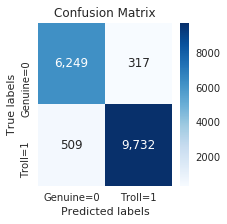

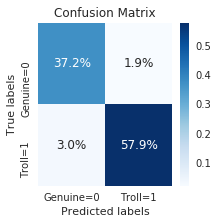

In [45]:
#Print confusion matrix results
sns.set(font_scale=1)  #Change to 3 for exporting
def plot_results_cm(cm):
    fmt = ','
    label_names = ['Genuine=0', 'Troll=1']
    for i in range(2):
        if i == 1:
            cm = cm / np.sum(cm)
            fmt = '.1%'
    
        fig, ax = plt.subplots(figsize=(3,3))  #Change to 12, 12 for exporting
        sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, ax = ax, fmt=fmt); #annot=True to annotate cells

        #labels, title and ticks
        ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
        ax.set_title('Confusion Matrix'); 
        ax.xaxis.set_ticklabels(label_names); ax.yaxis.set_ticklabels(label_names)

print('CLASSIFICATION REPORT:')
print(classification_report(y_true, y_pred, target_names=['Genuine', 'Russian']))
print('ROC AUC SCORE: {:.1%}'.format(roc_auc_score(y_true, y_pred)))

plot_results_cm(cnf_matrix)
sns.set(font_scale=1)

In [46]:
#Mean Metadata Values
cols = ['retweet_count', 'favorite_count', 'num_hashtags','num_urls','num_mentions',
        'statuses_count', 'followers_count', 'friends_count', 'favourites_count', 'listed_count',
        'seq_len_cantok',
       ]

agg_dict = dict()
for col in cols:
    agg_dict[col] = 'mean'
    
print('Table of Mean Values by Result:')
df_alltweets.groupby(['result']).agg(agg_dict).reset_index()

#Interesting results ... outliers might be dragging up the means, let's try medians next

Table of Mean Values by Result:


,result,favorite_count,listed_count,statuses_count,seq_len_cantok,num_mentions,num_urls,followers_count,favourites_count,friends_count,num_hashtags,retweet_count
0,"False Negative (pred=Genunie, target=Russian)",6.754420,30.640472,2539.581532,12.218075,0.055010,0.035363,3711.850688,1305.383104,2652.159136,0.277014,7.100196
1,"False Positive (pred=Russian, target=Genunie)",1.138801,110.264984,25192.678233,14.876972,0.258675,0.287066,12046.151420,3811.006309,776.974763,0.564669,1.009464
2,"True Negative (pred=Genunie, target=Genunie)",0.622500,33.920627,23609.439590,13.026244,0.613698,0.122100,1814.331733,5150.252200,711.274604,0.207713,0.243719
3,"True Positive (pred=Russian, target=Russian)",13.176839,36.527949,4564.105836,19.356145,0.009762,0.070078,4035.602959,2366.840321,3077.401459,0.484381,15.213009


In [47]:
#Median (or whatever quantile you want) Metadata Values
agg_dict = dict()
for col in cols:
    agg_dict[col] = lambda x : x.quantile(0.5)   #0.5 for median
    
print('Table of Median Values by Result:')
metadata_median_by_rslt = df_alltweets.groupby(['result']).agg(agg_dict).reset_index()
metadata_median_by_rslt

Table of Median Values by Result:


,result,favorite_count,listed_count,statuses_count,seq_len_cantok,num_mentions,num_urls,followers_count,favourites_count,friends_count,num_hashtags,retweet_count
0,"False Negative (pred=Genunie, target=Russian)",0.0,13.0,1659.0,10,0.0,0.0,1519.0,989.0,1415.0,0.0,0.0
1,"False Positive (pred=Russian, target=Genunie)",0.0,7.0,8467.0,14,0.0,0.0,522.0,897.0,564.0,0.0,0.0
2,"True Negative (pred=Genunie, target=Genunie)",0.0,5.0,11538.0,11,0.0,0.0,527.0,1913.0,420.0,0.0,0.0
3,"True Positive (pred=Russian, target=Russian)",0.0,21.0,2010.0,19,0.0,0.0,1704.0,1778.0,1555.0,0.0,0.0


In [48]:
def fetch_most_common_tokens(rslt, limit=None):
    '''Get the top most common result tokens from a result type
    '''
    return pd.Series([item for sublist in df_alltweets['text_cantok'][df_alltweets['rslt'] == rslt]
                      for item in sublist]).value_counts()[0:limit]

In [49]:
#Get counts of most common words by result group
rslt_list = ['FP', 'FN', 'TP', 'TN']
for rslt in rslt_list:
    print('\n{}:'.format(rslt))    
    print(fetch_most_common_tokens(rslt, 50))


FP:
<hashtag>    163
.            153
<url>        137
<allcaps>    106
the          100
'             86
<user>        83
,             82
to            76
you           76
i             66
a             63
in            60
:             55
and           55
of            54
it            46
!             41
is            37
"             36
s             35
that          33
t             31
-             31
rt            31
for           29
are           28
?             28
be            27
<repeat>      25
<number>      24
your          23
my            22
on            20
have          20
this          19
but           18
with          17
not           17
do            16
will          15
all           14
if            14
so            14
can           13
they          13
what          13
we            13
as            13
how           12
dtype: int64

FN:
.            223
<hashtag>    200
<user>       181
<url>        173
i            141
the          138
'            136
,       

In [50]:
#Eliminate words that happen in all 4 (effectively makes a stop-word list)

#Get lists 0 - limit
limit = 150

#Store lists in dictionary
rslt_top_x = dict()
for rslt in rslt_list:
    rslt_top_x[rslt] = fetch_most_common_tokens(rslt, limit)
    
#Find intersection of all 4 and make a set of it
common_rslts = (set(rslt_top_x['FP'].index.values.tolist()) & 
                set(rslt_top_x['FN'].index.values.tolist()) & 
                set(rslt_top_x['TP'].index.values.tolist()) & 
                set(rslt_top_x['TN'].index.values.tolist())
               )
print('Number of words in common across all 4 result types:', len(common_rslts), '\n')

#Subtract that set from each list and report each list
print('REMAINING WORDS NOT IN COMMON ACROSS ALL 4 LISTS:')
for rslt in rslt_list:
    print('{}:'.format(result_lingo[rslt]))    
    print(rslt_top_x[rslt][~rslt_top_x[rslt].index.isin(list(common_rslts))][0:30])
    print()
    #Notice the ~ operator negates the 'isin' command


Number of words in common across all 4 result types: 85 

REMAINING WORDS NOT IN COMMON ACROSS ALL 4 LISTS:
False Positive (pred=Russian, target=Genunie):
rt           31
…            10
by            9
says          8
something     8
ever          8
obama         7
re            7
could         7
other         7
much          7
police        7
never         7
his           6
these         6
things        6
say           6
any           6
over          6
against       6
who           6
had           6
does          6
yes           5
going         5
us            5
news          5
fight         5
those         5
let           5
dtype: int64

False Negative (pred=Genunie, target=Russian):
think      17
wanna      13
…          12
from       12
go         12
an         12
right      12
die        11
😂          11
life       11
lol        11
u          10
never      10
day        10
sure        9
because     9
girl        9
ll          9
man         8
being       8
ve          8
some      

### Review Preds Distribution; Investigate Errors

/home/brandon_cummings/.local/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


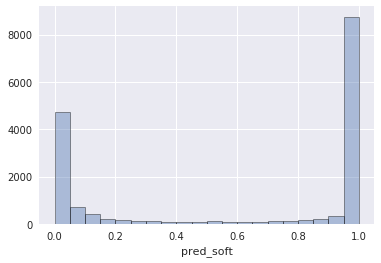

In [51]:
plot_vals = df_alltweets[~df_alltweets['pred_soft'].isnull()]['pred_soft']
hues = df_alltweets[~df_alltweets['pred_soft'].isnull()]['rslt']

#df_alltweets.loc[df_alltweets.index[cutoff_dev_test:cutoff_test_end], 'pred_soft']
plot_vals

sns.distplot(plot_vals, kde=False, bins=20, 
             hist_kws=dict(edgecolor='black', linewidth=1))



Text(0.5,0.98,'Distribution of Softmax Predictions')

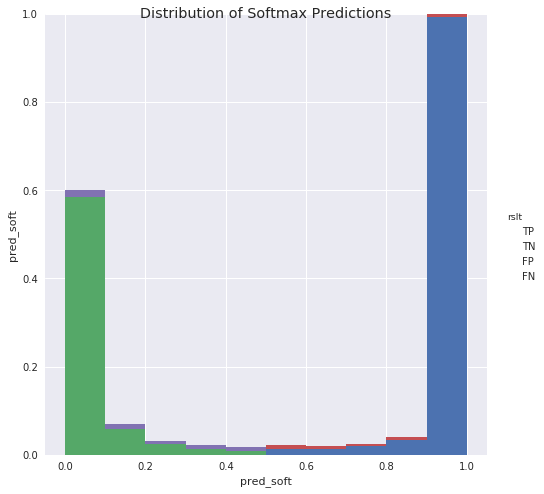

In [52]:
#plt.rcParams['figure.figsize']=(2,2)
g = sns.pairplot(df_alltweets[~df_alltweets['pred_soft'].isnull()],
                 hue='rslt', vars=['pred_soft'], size=7
                )

g.fig.suptitle('Distribution of Softmax Predictions')

#Not sure how to either display correctly or remove the legend (it's pretty obvious)

Above, we observe that the false positives (predicts > 0.5 but target = 0) are a little more prevalent than the false negatives.

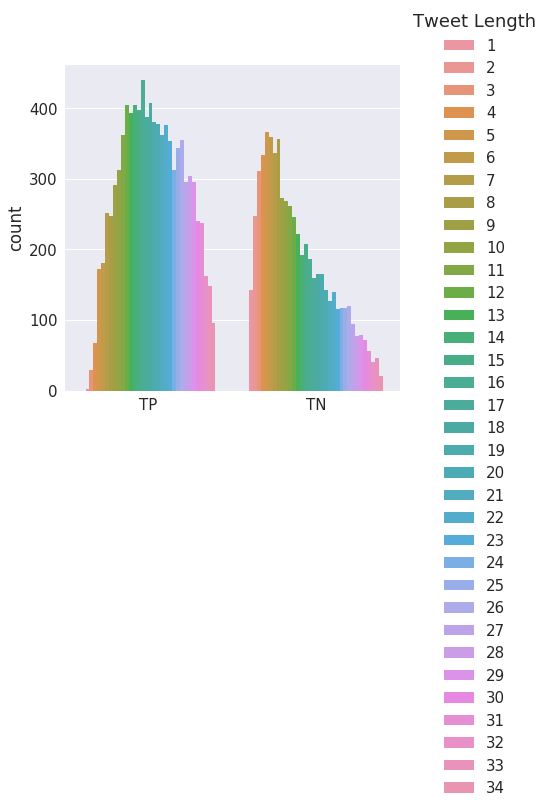

In [53]:
#Tweet length

# hue = rslt
# seq length = category
# bar length = frequency
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[(df_alltweets['seq_len_cantok'] <= 34) &
                                                                     ((df_alltweets['rslt'] == 'TP') |
                                                                     (df_alltweets['rslt'] == 'TN') )
                                                                    ]
                  )
ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Tweet Length')
ax.xaxis.set_label_text('')
#ax.xaxis.set_ticklabels(['True Positives', 'True Negatives'])
sns.set(font_scale=1)

# fig, ax = plt.subplots()
# fig.set_size_inches(14,6)
# ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[df_alltweets['seq_len_cantok'] <= 34])
# ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Tweet Length')

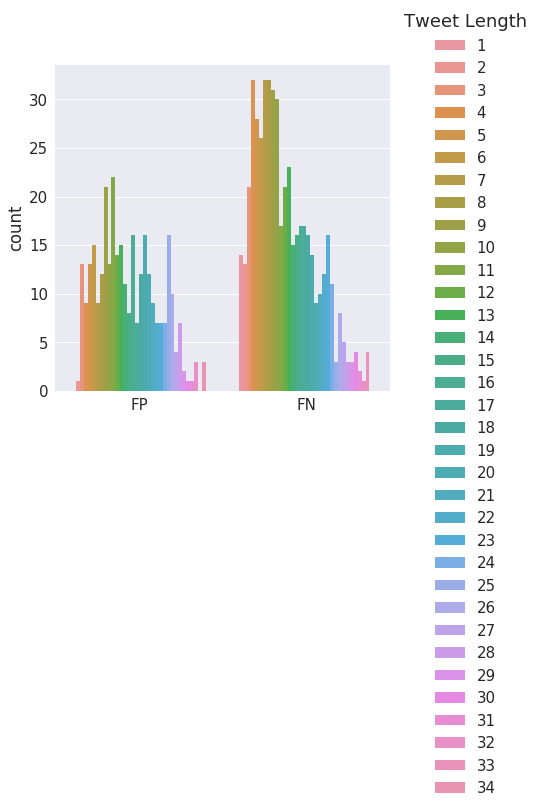

In [54]:
#FP and FN only
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[(df_alltweets['seq_len_cantok'] <= 34) &
                                                                     ((df_alltweets['rslt'] == 'FP') |
                                                                     (df_alltweets['rslt'] == 'FN') )
                                                                    ]
                  )
ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Tweet Length')
ax.xaxis.set_label_text('')
#ax.xaxis.set_ticklabels(['False Negatives', 'False Positives'])
sns.set(font_scale=1)

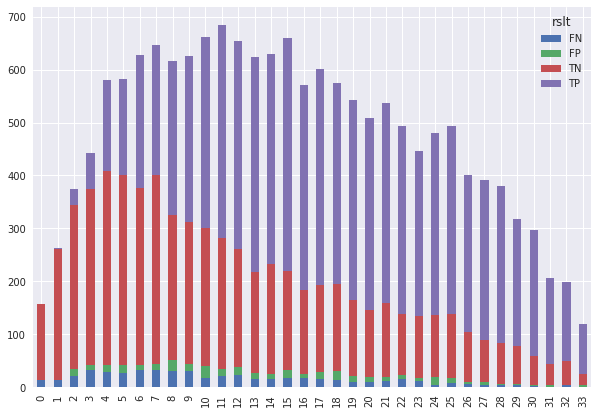

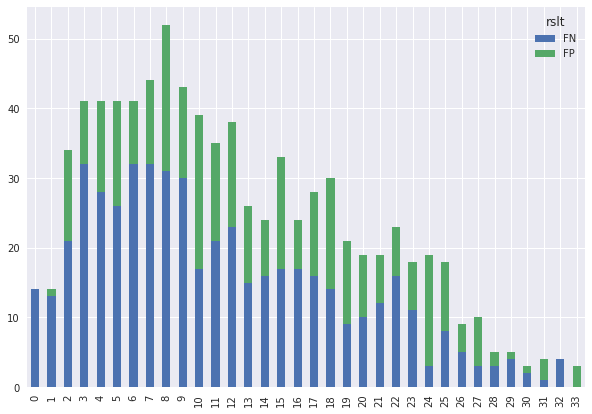

In [55]:
df_plt_data = pd.crosstab(df_alltweets['seq_len_cantok'],df_alltweets['rslt']).reset_index()
df_plt_data = df_plt_data[df_plt_data['seq_len_cantok'] <= 34]
df_plt_data.loc[:,['FN','FP', 'TN','TP']].plot.bar(stacked=True, figsize=(10,7))
df_plt_data.loc[:,['FN','FP']].plot.bar(stacked=True, figsize=(10,7))

True negatives tend to be shorter, but I see no pattern in the rest.

### Inspect actual tweet text of false postives and negatives

In [56]:
#Print out false positives & negatives
pd.set_option('max_colwidth', 10000)  #Prevent ellipsis in cells

cols = ['text', 'text_cantok', 'pred_soft', 'result']

df_alltweets[(df_alltweets['rslt'] == 'FP') & (df_alltweets['pred_soft'] > 0.9)][cols]

,text,text_cantok,pred_soft,result
250151,Weave on the piece of wood #weak #triniproblems @CNC3TV,"[weave, on, the, piece, of, wood, <hashtag>, weak, <hashtag>, triniproblems, <user>]",0.972343,"False Positive (pred=Russian, target=Genunie)"
250164,RT @PabloWeather: Third alarm in San Gabriel last night at San Gabriel Bl and Live Oak St. http://t.co/F1h7Kgyt33,"[rt, <allcaps>, <user>, :, third, alarm, in, san, gabriel, last, night, at, san, gabriel, bl, and, live, oak, st, ., <url>]",0.964823,"False Positive (pred=Russian, target=Genunie)"
250445,@DickMorrisTweet Do you believe an October surprise (i.e. Allred) could damage Romney's chances? Would this change your opinion?,"[<user>, do, you, believe, an, october, surprise, (, i, ., e, ., allred, ), could, damage, romney, ', s, chances, ?, would, this, change, your, opinion, ?]",0.945808,"False Positive (pred=Russian, target=Genunie)"
250941,#ProudToBeAFanOf beans,"[<hashtag>, proudtobeaf, <allcaps>anof, beans]",0.961746,"False Positive (pred=Russian, target=Genunie)"
251138,Spaeter Aprilscherz?! Chinesische Regierung will Bevölkerung mit „sozialem Bonitätssystem“ umfassend kontrollieren http://t.co/KEqB6iUiR1,"[spaeter, aprilscherz, !, <repeat>, chinesische, regierung, will, bevölkerung, mit, „, sozialem, bonitätssystem, “, umfassend, kontrollieren, <url>]",0.994705,"False Positive (pred=Russian, target=Genunie)"
251194,#EndVVIPRaj I am denying any special treatment to my civil servant. My servant will not have a any special treatment which i am not getting,"[<hashtag>, endvvipr, <allcaps>aj, i, am, denying, any, special, treatment, to, my, civil, servant, ., my, servant, will, not, have, a, any, special, treatment, which, i, am, not, getting]",0.987788,"False Positive (pred=Russian, target=Genunie)"
251305,Working People: A History of Labour in British Columbia https://t.co/fkgBNHZoVM,"[working, people, :, a, history, of, labour, in, british, columbia, <url>]",0.963974,"False Positive (pred=Russian, target=Genunie)"
251514,RT @BarackOMamba: #GetMigosKnighted2015,"[rt, <allcaps>, <user>, :, <hashtag>, getmigosknighted<number>]",0.998615,"False Positive (pred=Russian, target=Genunie)"
251880,how do you resist temptation#EMABiggestFans1D http://t.co/pk63u84KDX,"[how, do, you, resist, temptation<hashtag>, emab, <allcaps>iggestfans<number>d, <url>]",0.978705,"False Positive (pred=Russian, target=Genunie)"
252294,MORE: DOJ will not prosecute former Ferguson police officer for Michael Brown shooting death http://t.co/LWegr4LzQD http://t.co/8srNAJkeYb,"[more, <allcaps>, :, doj, <allcaps>, will, not, prosecute, former, ferguson, police, officer, for, michael, brown, shooting, death, <url>, <url>]",0.993583,"False Positive (pred=Russian, target=Genunie)"


In [57]:
pd.set_option('max_colwidth', 200)  #Oddly, this prevents crazy cell heights
df_alltweets[(df_alltweets['rslt'] == 'FN') & (df_alltweets['pred_soft'] < 0.1)][cols]
#df_alltweets[(df_alltweets['rslt'] == 'FN') ]

,text,text_cantok,pred_soft,result
250115,You'd better use some Tic Tacs just in case you start kissing her @realDonaldTrump https://t.co/1MBaRULUIY,"[you, ', d, better, use, some, tic, tacs, just, in, case, you, start, kissing, her, <user>, <url>]",0.053658,"False Negative (pred=Genunie, target=Russian)"
250308,I was sleeping when my mom called me and asked if I was okay. She told me to turn on the TV… #My911Story,"[i, was, sleeping, when, my, mom, called, me, and, asked, if, i, was, okay, ., she, told, me, to, turn, on, the, tv, <allcaps>, …, <hashtag>, my<number>story]",0.069485,"False Negative (pred=Genunie, target=Russian)"
250344,still don't know how to ruin my day? Wake me up with a phone call!!,"[still, don, ', t, know, how, to, ruin, my, day, ?, wake, me, up, with, a, phone, call, !, <repeat>]",0.038392,"False Negative (pred=Genunie, target=Russian)"
250479,"@larrykim @Inc all the advices take quite a time to be brought to life, well...i don`t know...","[<user>, <user>, all, the, advices, take, quite, a, time, to, be, brought, to, life, ,, well, ., <repeat>i, don, `, t, know, ., <repeat>]",0.030139,"False Negative (pred=Genunie, target=Russian)"
250482,Did Selena Gomez Get Breast Implants??!,"[did, selena, gomez, get, breast, implants, !, <repeat>]",0.012420,"False Negative (pred=Genunie, target=Russian)"
250491,on a day like this I just wanna stay in bed,"[on, a, day, like, this, i, just, wanna, stay, in, bed]",0.020594,"False Negative (pred=Genunie, target=Russian)"
250530,Staying at a mates tonight,"[staying, at, a, mates, tonight]",0.026070,"False Negative (pred=Genunie, target=Russian)"
250580,3-D Printing... I think I'm gonna like it. 💻 (W/ Katherine Ann) IntelUSA Experience Zone! #spons https://t.co/d0N5Ipvq6E,"[<number>, -, d, printing, ., <repeat>, i, think, i, ', m, gonna, like, it, ., 💻, (, w, /, katherine, ann, ), intelusa, <allcaps>, experience, zone, !, <hashtag>, spons, <url>]",0.006623,"False Negative (pred=Genunie, target=Russian)"
250644,#MAGA,[maga],0.062285,"False Negative (pred=Genunie, target=Russian)"
250666,@POTUS_Tweets Sure,"[<user>, sure]",0.084024,"False Negative (pred=Genunie, target=Russian)"


### Is This Just a Political Word Classifier?

Let's hunt for political words in the True Negatives:

In [58]:
df_alltweets[(df_alltweets['target'] == 0) & 
             (df_alltweets['text'].str.contains('donald', case=False))
            ][cols]

,text,text_cantok,pred_soft,result
1576,yayyyy @donald on @CBSNews at 4:51am,"[yay, <elong>, <user>, on, <user>, at, <number>am]",NaN,NaN
13634,"Who authored that terrible post that went ""Old McDonald had a Farm &lt;Bastille Voice&gt; E-I-E-I-O"" because GET OUT OF HERE","[who, authored, that, terrible, post, that, went, "", old, mcdonald, had, a, farm, &, lt, ;, bastille, voice, &, gt, ;, e, -, i, -, e, -, i, -, o, "", because, get, <allcaps>, out, <allcaps>, of, <a...",NaN,NaN
17969,Americans Taste Test British McDonald’s http://t.co/wNjV6Qj8G3 via @heyyyella @buzzfeed this is great. It's just great.,"[americans, taste, test, british, mcdonald, ’, s, <url>, via, <user>, <user>, this, is, great, ., it, ', s, just, great, .]",NaN,NaN
18525,I think we aren't allowed Bavk mcdonalds fav agatha oops,"[i, think, we, aren, ', t, allowed, bavk, mcdonalds, fav, agatha, oops]",NaN,NaN
22667,LOL people think @HarveyLevinTMZ orchestrated this whole #DonaldSterling scandal because he's a @Lakers fan. #Ignorance,"[lol, <allcaps>, people, think, <user>, orchestrated, this, whole, <hashtag>, donaldsterling, scandal, because, he, ', s, a, <user>, fan, ., <hashtag>, ignorance]",NaN,NaN
26503,"That's no weak sauce, #McDonald's is selling their limited edition sauce from The Big Mac on #EBAY at a starting bid of $18,000 #charity","[that, ', s, no, weak, sauce, ,, <hashtag>, mcdonald, ', s, is, selling, their, limited, edition, sauce, from, the, big, mac, on, ebay, at, a, starting, bid, of, $, <number>, <hashtag>, charity]",NaN,NaN
27079,Im eating mcdonalds because im drunk.,"[im, eating, mcdonalds, because, im, drunk, .]",NaN,NaN
28760,Minorities supporting Donald Sterling remember when said enemy Sterling was referring to you too!,"[minorities, supporting, donald, sterling, remember, when, said, enemy, sterling, was, referring, to, you, too, !]",NaN,NaN
29365,MOTH JOKE. http://t.co/VGEOBqb01q “@Peyton_Drinking: @Filmdrunk Hey what's the Norm McDonald joke you guys always talk about watching”,"[moth, <allcaps>, joke, <allcaps>, ., <url>, “, <user>, :, <user>, hey, what, ', s, the, norm, mcdonald, joke, you, guys, always, talk, about, watching, ”]",NaN,NaN
29935,@donaldmiller i spent time w Disney animator/producer today. You need to know him &amp; vice versa. How might I introduce the 2 of you.,"[<user>, i, spent, time, w, disney, animator, /, producer, today, ., you, need, to, know, him, &, amp, ;, vice, versa, ., how, might, i, introduce, the, <number>, of, you, .]",NaN,NaN


In [59]:
(df_alltweets['target'] == 1) & (df_alltweets['text'].str.contains('trump', case=False))

0          True
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16         True
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
266777    False
266778    False
266779    False
266780     True
266781    False
266782    False
266783    False
266784     True
266785    False
266786    False
266787    False
266788    False
266789    False
266790    False
266791    False
266792     True
266793     True
266794    False
266795    False
266796    False
266797    False
266798    False
266799    False
266800    False
266801    False
266802    False
266803    False
266804    False
266805    False
266806    False
Length: 266807, dtype: b

In [60]:
words = ['trump', 'donald', 'hillary', 'clinton', 'bernie', 'sanders', 'obama', 'bush',
         'election', 'vote', '2018', 'polit', 'islam', 'muslim', 'washington', 'president', 
         'country'
        ]
len_troll = sum(df_alltweets['target'] == 1)
len_genuine = sum(df_alltweets['target'] == 0)
print('Number of troll tweets:', len_troll)
print('Number of genuine tweets:', len_genuine)

for word in words:
    print(word.upper(), ':\n', df_alltweets[(df_alltweets['text'].str.contains(word, case=False))]['target'] \
          .value_counts(), sep='')
    print('\n', df_alltweets[(df_alltweets['text'].str.contains(word, case=False))]['target'] \
          .value_counts() / (len_troll, len_genuine), sep='')
    print()

Number of troll tweets: 163810
Number of genuine tweets: 102997
TRUMP:
1    21869
0       24
Name: target, dtype: int64

1    0.133502
0    0.000233
Name: target, dtype: float64

DONALD:
1    5101
0      96
Name: target, dtype: int64

1    0.031140
0    0.000932
Name: target, dtype: float64

HILLARY:
1    7801
0      35
Name: target, dtype: int64

1    0.047622
0    0.000340
Name: target, dtype: float64

CLINTON:
1    6266
0      20
Name: target, dtype: int64

1    0.038252
0    0.000194
Name: target, dtype: float64

BERNIE:
1    647
0      4
Name: target, dtype: int64

1    0.003950
0    0.000039
Name: target, dtype: float64

SANDERS:
1    568
0      5
Name: target, dtype: int64

1    0.003467
0    0.000049
Name: target, dtype: float64

OBAMA:
1    6430
0     136
Name: target, dtype: int64

1    0.039253
0    0.001320
Name: target, dtype: float64

BUSH:
1    471
0     43
Name: target, dtype: int64

1    0.002875
0    0.000417
Name: target, dtype: float64

ELECTION:
1    2698
0     100

In [61]:
#Now let's look to see which contain ANY of these words
unique_tweets = df_alltweets[df_alltweets['text_cantok'].map(set) & set(words)]['target'].value_counts()
print('ALL WORDS:\n', unique_tweets, sep='')
print('\n', unique_tweets / (len_troll, len_genuine), sep='')

"""
#Conclusion:  20% of troll tweets contain these words vs. 1% of genuine tweets.  So while this likely helps predict 
the class for those 20% of tweets, it still leaves 80% to be predicted by other means.
""";

ALL WORDS:
1    32454
0      625
Name: target, dtype: int64

1    0.198120
0    0.006068
Name: target, dtype: float64


In [62]:
#Let's look at the tweets that don't contain these words to see if we can see any patterns.
df_alltweets[(~df_alltweets['text'].str.contains('|'.join(words), case=False)) &
             (df_alltweets['target'] == 1)
            ]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text,seq_len_cantok,pred,pred_soft,result,rslt
6,880409251470090240,RT @ZDFheute: Rund um den G20-Gipfel: Berlin verbietet Auftritt von #Erdogan in Deutschland. \nhttps://t.co/7Sbs3hKZ9J,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[rt, <allcaps>, <user>, :, rund, um, den, g<number>, -, gipfel, :, berlin, verbietet, auftritt, von, <hashtag>, erdogan, in, deutschland, ., <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",21,NaN,NaN,NaN,NaN
7,578219146401419264,Think of all the beauty still left around you and be happy. – Anne Frank,1656685598,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1999.0,3242.0,3420.0,1863.0,35.0,"[think, of, all, the, beauty, still, left, around, you, and, be, happy, ., –, anne, frank]","[[0.397489994764328, 0.5261399745941162, 0.06063099950551987, -0.04740000143647194, -0.5239599943161011, -0.014643000438809395, 0.9059900045394897, 0.28095000982284546, 0.19418999552726746, 0.8859...",16,NaN,NaN,NaN,NaN
8,826161306092892169,RT @carrieksada: Amazing how @SenSchumer can manufacture his #FakeTears for refugees but none for our homeless vets. Shame on you Senator!…,2533653547,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1831.0,2668.0,2884.0,1325.0,46.0,"[rt, <allcaps>, <user>, :, amazing, how, <user>, can, manufacture, his, <hashtag>, faketears, for, refugees, but, none, for, our, homeless, vets, ., shame, on, you, senator, !, …]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",27,NaN,NaN,NaN,NaN
17,706884755854401536,RT @SenFrankNiceley: #GoingHogWild https://t.co/5aaGNtYqxQ,1649967228,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,2100.0,1457.0,1262.0,2001.0,21.0,"[rt, <allcaps>, <user>, :, <hashtag>, goinghogwild, <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",7,NaN,NaN,NaN,NaN
21,810849848123604993,RT @ChrixMorgan: #ThingsYouCantIgnore a No Bra day https://t.co/eBzJoThsj6,2882013788,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,18466.0,24344.0,21953.0,9122.0,113.0,"[rt, <allcaps>, <user>, :, <hashtag>, thingsyoucantignore, a, no, bra, day, <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",11,NaN,NaN,NaN,NaN
22,814144420455084032,RT @UncleBooze1: Karma is a b!tch #2016In4Words,2533001646,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1,3379.0,1957.0,1782.0,2416.0,15.0,"[rt, <allcaps>, <user>, :, karma, is, a, b, !, tch, <hashtag>, <number>in<number>words]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",12,NaN,NaN,NaN,NaN
23,667335537796083712,RT @JewhadiTM: 😂😂😂 Russia Insults U.S. War Strategy With Weird Cat Metaphor https://t.co/qcmAia6XSn,1690487623,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2433.0,3229.0,3290.0,2157.0,42.0,"[rt, <allcaps>, <user>, :, 😂, 😂, 😂, russia, insults, u, ., s, ., war, strategy, with, weird, cat, metaphor, <url>]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",20,NaN,NaN,NaN,NaN
24,823860042512351233,"RT @BlastingNews: Roger Federer, Stan Wawrinka advance to semifinal at 2017 Australian Open https://t.co/f4Rf

In [63]:
#Let's look at the highest percentage difference between target == 0 vs 1

#Build dictionary
token_dict_0 = defaultdict(float)
token_dict_1 = defaultdict(float)

# len_troll = sum(df_alltweets['target'] == 1)
# len_genuine = sum(df_alltweets['target'] == 0)

for df_row in df_alltweets[df_alltweets['target'] == 0].itertuples():
    temp_dict = defaultdict(int)
    for token in df_row.text_cantok:
        temp_dict[token]
    for k in temp_dict:
        token_dict_0[k] += 1 / len_genuine
        
for df_row in df_alltweets[df_alltweets['target'] == 1].itertuples():
    temp_dict = defaultdict(int)
    for token in df_row.text_cantok:
        temp_dict[token]
    for k in temp_dict:
        token_dict_1[k] += 1 / len_troll

token_dict_diff = {key: token_dict_1[key] - token_dict_0.get(key, 0) for key in token_dict_1.keys()}

#Reverse option (results appears nearly, if not exactly, identical)
#token_dict_diff = {key: token_dict_0[key] - token_dict_1.get(key, 0) for key in token_dict_0.keys()}

In [64]:
test_word = 'rt'
print('WORD = {}, GENUINE: {:.2%}, TROLL: {:.2%}, DIFFERENCE: {:.2%}'.format(test_word,
                                                                             token_dict_0[test_word],
                                                                             token_dict_1[test_word],
                                                                             token_dict_diff[test_word]
                                                                            ))

WORD = rt, GENUINE: 1.15%, TROLL: 66.17%, DIFFERENCE: 65.02%


In [65]:
od = sorted(token_dict_diff.items(), key = itemgetter(1), reverse = True)

#Alternate method, but we don't really need it to be an OrderedDict
#od = OrderedDict(sorted(token_dict_diff.items(), key = itemgetter(1), reverse = True))

od

[('rt', 0.6501982368236824),
 (':', 0.6193438845013491),
 ('<allcaps>', 0.5693844612553092),
 ('<hashtag>', 0.37714509975293775),
 ('<url>', 0.34647168301113795),
 ('…', 0.23808231225699159),
 ('<user>', 0.2297649352466617),
 ('trump', 0.09642187264084201),
 ('the', 0.07021427508690106),
 ('to', 0.062467095326953714),
 ('of', 0.056656015254882355),
 ('-', 0.05126788800302256),
 ('in', 0.05003189920939448),
 ('s', 0.04646731836702979),
 (',', 0.03867898909746173),
 ('’', 0.03408639455471894),
 ('hillary', 0.03150107628681341),
 ('obama', 0.031107550434851985),
 ('clinton', 0.03091834390195978),
 ('"', 0.028718417447396803),
 ('for', 0.027343560971764685),
 ('is', 0.024003398917124386),
 ('politics', 0.023636747807338633),
 ('<number>', 0.021710285245582273),
 ('news', 0.02000193259357037),
 ('on', 0.019880672076217992),
 ('by', 0.01921833200463103),
 ('amp', 0.018394424251391456),
 (';', 0.017149106417115145),
 ('our', 0.01706084779800146),
 ('donald', 0.016878791184456034),
 ('we', 0.0

In [66]:
#Show in reverse order:
od[::-1]

[('i', -0.12308024939660243),
 ('my', -0.042186886115493996),
 ('me', -0.039800490572800246),
 ('<repeat>', -0.03799237475531289),
 ('<smile>', -0.030718704187413827),
 ('so', -0.026156195280653428),
 ('<elong>', -0.025117230793713058),
 ('m', -0.024425447395407533),
 ('you', -0.022952420339422394),
 ('?', -0.022916590906011725),
 ('!', -0.02218901541431359),
 ('lol', -0.01766066583064943),
 ('it', -0.016608317285965013),
 ('just', -0.01473975648786863),
 ('like', -0.012319917366796187),
 ('love', -0.010628149116122932),
 ('good', -0.010326155662385239),
 ('na', -0.010183302842596755),
 ('but', -0.00994184932004925),
 ('haha', -0.009851216107171901),
 ('de', -0.009149485719114888),
 ('que', -0.008239226715012812),
 ('oh', -0.008116279136025719),
 ('hahaha', -0.008089466805117646),
 ('today', -0.008018509043208671),
 ('“', -0.007936913914451801),
 ('too', -0.00792407312564093),
 ('<sadface>', -0.007779006393098734),
 ('im', -0.007711701382753372),
 ('ko', -0.0067766044503799585),
 ('got

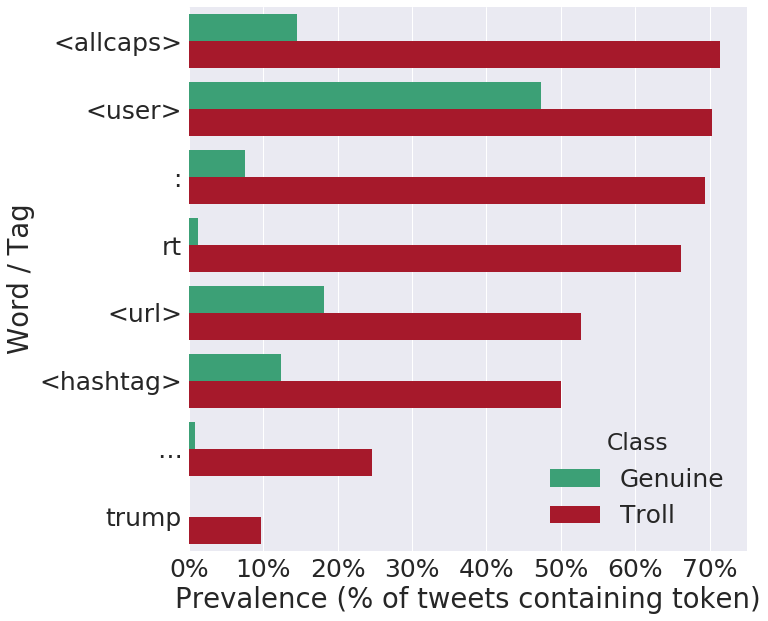

In [67]:
#Let's graph this (use a bar graph)

#Build data
diff_words = ['<allcaps>', '<user>', ':', 'rt', '<url>', '<hashtag>', '…', 'trump', 'i', 'my', 'me']
diff_words = ['<allcaps>', '<user>', ':', 'rt', '<url>', '<hashtag>', '…', 'trump']

df_plot = pd.DataFrame(columns=['Genuine', 'Troll'], index=diff_words)

for word in diff_words:
    df_plot.loc[word, 'Genuine'] = token_dict_0[word]
    df_plot.loc[word, 'Troll'] = token_dict_1[word]
df_plot.reset_index(inplace=True)


plot_data = pd.melt(df_plot, id_vars=['index'], value_vars=['Genuine', 'Troll'])

plot_data.rename(index=str, columns={'index': 'Word', 'variable': 'Class', 'value': 'Prevalence'}, inplace=True)


sns.set(font_scale=2.5)
fig, ax = plt.subplots()
fig.set_size_inches(10,10)

newPal   = dict(Genuine = '4878CF', Troll = '4878CF')

ax = sns.barplot(data=plot_data, y='Word', x='Prevalence', hue='Class', palette=['#2bb179', '#be0119'])
#sns.diverging_palette(133, 10, n=2)
ax.set_xlabel('Prevalence (% of tweets containing token)')
ax.set_ylabel('Word / Tag')
ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
ax.set_xticklabels(['0%', '10%', '20%', '30%', '40%', '50%', '60%', '70%'])

sns.set(font_scale=1)

In [68]:
#Let's re-evaluate all tweets with the most common tags ...
#words = ['rt', ':', '<allcaps>', '<hashtag>', '<url>', '…', '<user>', 'trump']
words = ['rt', ':', '<allcaps>', '<hashtag>', '<url>', '…', 'trump']
words = ['rt', ':', '<allcaps>', 'trump']

unique_tweets = df_alltweets[df_alltweets['text_cantok'].map(set) & set(words)]['target'].value_counts()

print('ALL WORDS:\n', unique_tweets, sep='')
print('\n', unique_tweets / (len_troll, len_genuine), sep='')

ALL WORDS:
1    126185
0     20386
Name: target, dtype: int64

1    0.770313
0    0.197928
Name: target, dtype: float64


### Inspect Unknown Embeddings

In [69]:
#Load unknown embedding
unk_embed = np.load('data/GloVe_Unknown_50.npy')
unk_embed

array([-0.75581  ,  0.65351  ,  0.017113 , -0.46716  , -0.41164  ,
       -0.15223  , -0.32018  ,  0.13096  , -0.47702  ,  0.30387  ,
       -0.49072  ,  0.49712  , -0.76242  , -0.75837  ,  0.15845  ,
        0.12721  ,  0.26129  ,  0.061279 , -0.44009  ,  0.23058  ,
       -0.82653  ,  0.073613 ,  0.25677  , -0.35542  ,  0.32554  ,
        0.71409  ,  0.94323  , -0.018156 , -0.55853  ,  0.88851  ,
        0.070136 ,  0.012131 ,  0.37727  ,  0.06488  , -0.53939  ,
        0.22079  , -0.40003  ,  0.55029  ,  0.85582  , -0.078582 ,
       -0.34651  ,  0.71381  ,  1.0456   , -0.79633  , -1.1146   ,
        0.0019505,  0.28528  , -0.33569  ,  0.40309  , -0.54987  ])

In [70]:
#Count most common unknown words
df_alltweets[~df_alltweets['rslt'].isnull()]  #Remember ~ negates

unk_dict = dict()
unk_dict['TP'] = defaultdict(int)
unk_dict['TN'] = defaultdict(int)
unk_dict['FP'] = defaultdict(int)
unk_dict['FN'] = defaultdict(int)

#For each df_row ...
for df_row in df_alltweets[~df_alltweets['rslt'].isnull()].itertuples():
    #print(df_row.embedded_text)
    unk_count = 0
    for i, embed_row in enumerate(df_row.embedded_text):
        if np.allclose(embed_row, unk_embed):
            unk_dict[df_row.rslt][df_row.text_cantok[i]] += 1
            unk_count += 1
    
    df_alltweets.loc[df_alltweets.index[df_row.Index], 'unk_count'] = unk_count

unk_dict

{'FN': defaultdict(int,
             {'<allcaps><number>': 2,
              '<allcaps>aitingroom': 1,
              '<allcaps>andy': 1,
              '<allcaps>avear': 1,
              '<allcaps>awards<number>': 1,
              '<allcaps>earned': 2,
              '<allcaps>ebate': 1,
              '<allcaps>exy': 1,
              '<allcaps>ifelessonsil': 2,
              '<allcaps>ighttoknow': 1,
              '<allcaps>mthankfulfor': 1,
              '<allcaps>ongorband': 2,
              '<allcaps>onspies': 1,
              '<allcaps>ovehillary': 1,
              '<allcaps>owers': 1,
              '<allcaps>rime': 1,
              '<allcaps>runch': 1,
              '<allcaps>s': 2,
              '<allcaps>tartcryingwhen': 2,
              '<elong>executive': 1,
              '<elong>nh': 1,
              '<number><number>': 1,
              '<number>bama': 1,
              '<number>electionin<number>words': 1,
              '<number>g': 1,
              '<number>nd': 1,
            

In [71]:
df_alltweets[~df_alltweets['rslt'].isnull()]

,tweet_id,text,user_id,in_reply_to_status_id,retweeted_status_id,retweet_count,favorite_count,num_hashtags,num_urls,num_mentions,target,statuses_count,followers_count,friends_count,favourites_count,listed_count,text_cantok,embedded_text,seq_len_cantok,pred,pred_soft,result,rslt,unk_count
250000,569106626315096064,We accept the love we think we deserve.,0,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,"[we, accept, the, love, we, think, we, deserve, .]","[[0.7005699872970581, 1.242900013923645, 0.14358000457286835, -0.047922998666763306, -0.2265399992465973, 0.052122000604867935, 0.277539998292923, 0.007794300094246864, 0.19900000095367432, 0.0289...",9,1.0,0.684912,"True Positive (pred=Russian, target=Russian)",TP,0.0
250001,771022042510467072,RT @prisonculture: Pay attention to how this gets discussed (and not discussed). It'll be instructive. Take care Twitter.,1680366068,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1356.0,571.0,470.0,1365.0,7.0,"[rt, <allcaps>, <user>, :, pay, attention, to, how, this, gets, discussed, (, and, not, discussed, ), ., it, ', ll, be, instructive, ., take, care, twitter, .]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",27,1.0,0.889919,"True Positive (pred=Russian, target=Russian)",TP,0.0
250002,578244440919285760,This is how music should make you feel. I’m in heaven 😊 😊 😊,1649487510,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,1935.0,909.0,859.0,2026.0,13.0,"[this, is, how, music, should, make, you, feel, ., i, ’, m, in, heaven, 😊, 😊, 😊]","[[0.39070001244544983, 0.13815000653266907, 0.4275200068950653, -0.6054099798202515, 0.3242399990558624, -0.008028900250792503, 1.2812999486923218, 0.20879000425338745, 0.13549000024795532, 0.0656...",17,1.0,0.909773,"True Positive (pred=Russian, target=Russian)",TP,3.0
250003,507504153526927360,I'm thrilled about my 7-7 shift today!! Whoo,497557514,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0,7688.0,197.0,206.0,1056.0,1.0,"[i, ', m, thrilled, about, my, <number><number>, shift, today, !, <repeat>, whoo]","[[-0.04314799979329109, 0.5039299726486206, 0.27094998955726624, -0.11980000138282776, -0.5899099707603455, -0.32774001359939575, 0.1554899960756302, -0.546500027179718, 0.41690000891685486, 1.526...",12,0.0,0.000807,"True Negative (pred=Genunie, target=Genunie)",TN,1.0
250004,785741404395872256,RT @keriqbaum: @CharisseMSRD Too Late 😕,2531159968,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,1,4655.0,3696.0,3353.0,3778.0,21.0,"[rt, <allcaps>, <user>, :, <user>, too, late, 😕]","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",8,1.0,0.999513,"True Positive (pred=Russian, target=Russian)",TP,1.0
250005,714517744033640449,RT @masnRoch: RBI bloop single for Paul Janish with 1 out to give #orioles 2-0 lead. Reimold out between 2nd and 3rd,1657753759,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1685.0,849.0,852.0,2359.0,7.0,"[rt, <allcaps>, <user>, :, rbi, <allcaps>, bloop, single, for, paul, janish, with, <number>, out, to, give, <hashtag>, orioles, <number><number>, lead, ., reimold, out, between, <number>nd, and, <...","[[0.6824300289154053, 0.7358899712562561, 0.017528999596834183, -0.13763000071048737, 0.360289990901947, 0.5170400142669678, 0.19539999961853027, 0.7521899938583374, 0.43029001355171204, 1.0728000...",27,1.0,0.996546,"True Positive (pred=Russian, target=Russian)",TP,4.0
250006,565926778158325761,"#ItsOK2BeGay Nothing to do here, guys. Have sex with whoever you like. Bless you.",2587100717,0.000000e+00,0.0,0.0,0.0,1.0,0.0,0.0,1,1515.0,1688.0,1525.0,939.0,21.0,"[<hashtag>, itsok, <allcaps><number>begay, nothing, to, do, here, ,, guys, ., have, sex, with, whoever, you, like, ., bless, you, .]","[[1.0017999410629272, -0.7614099979400635, 0.11811999976634979, -1.3743000

In [72]:
for rslt in unk_dict:
    print(rslt)
    print(OrderedDict(sorted(unk_dict[rslt].items(), key = itemgetter(1), reverse = True)))
    print('\n\n\n')

TN
OrderedDict([('️', 60), ('<number><number>', 29), ('<allcaps><number>', 19), ('<allcaps>s', 17), ('<number>th', 16), ('<number>pm', 14), ('\xad', 10), ('<number>am', 9), ('<repeat>i', 8), ('methats', 7), ('<number>m', 6), ('<number>k', 6), ('x<number>', 6), ('<number>st', 6), ('ユルブリンナー', 5), ('<number>d', 5), ('<number>s', 4), ('vote<number>duk', 4), ('l<number>', 4), ('handwrittenatmidnight', 4), ('<number><number><number>', 4), ('<number>rd', 4), ('<repeat>but', 3), ('<number>a', 3), ('dfvm', 3), ('s<number>', 3), ('b<number>', 3), ('viplove', 3), ('facetimemenash', 3), ('<allcaps><user>', 3), ('shanky', 3), ('egyptwants<number>d', 3), ('<repeat>and', 3), ('a<number>', 3), ('<number>nd', 3), ('<number>mb', 2), ('<allcaps>cfs', 2), ('<repeat>we', 2), ('wankband', 2), ('brownthrush', 2), ('<number>yrs', 2), ('cohoes', 2), ('ily<number>', 2), ('xx<number>', 2), ('<number>km', 2), ('<number>p', 2), ('<repeat>hope', 2), ('ta<number>ad', 2), ('dealit', 2), ('<repeat>a', 2), ('la<number>

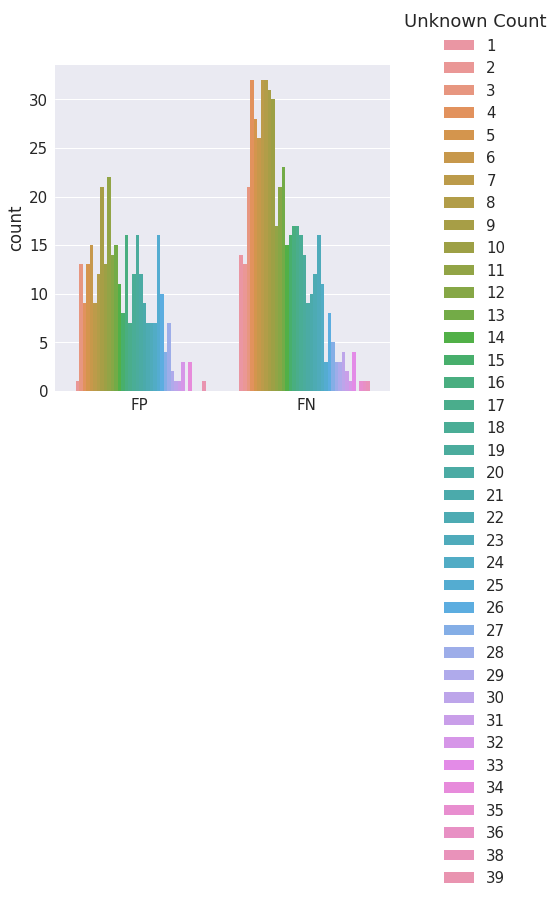

In [73]:
#Tweet length

# hue = rslt
# seq length = category
# bar length = frequency
sns.set(font_scale=1.5)
fig, ax = plt.subplots()
fig.set_size_inches(6,6)
ax = sns.countplot(x='rslt', hue='seq_len_cantok', data=df_alltweets[(df_alltweets['unk_count'] <= 34) &
                                                                     ((df_alltweets['rslt'] == 'FP') |
                                                                     (df_alltweets['rslt'] == 'FN') )
                                                                    ]
                  )
ax.legend(bbox_to_anchor=(1, 1.2), loc=0, title='Unknown Count')
ax.xaxis.set_label_text('')
#ax.xaxis.set_ticklabels(['True Positives', 'True Negatives'])
sns.set(font_scale=1)

#Of note, these can be longer than cutoff_length (currently 40, 99.5 percentile) because embeddings 
#aren't trimmed (or padded) in the dataframe.